In [1]:
## PATH settings
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.append(project_root)
COMMON_PATH = os.path.join(project_root, 'common')

In [2]:
## Bespoke class imports
from common.database.adatabase import ADatabase
from common.processor.processor import Processor as p
from financial_common.risk.rolling_factor_analysis import RollingFactorAnalysis
from financial_common.risk.single_index_capm import SingleIndexCAPM
from financial_common.indicator.indicator import Indicator
from financial_common.risk.benchmark import Benchmark
from financial_common.portfolio_management.kpi import KPI
from financial_common.metric.metric import Metric
from financial_common.portfolio_management.portfolio_selection import PortfolioSelection
from financial_common.risk.risk_type import RiskType
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
## Import standard packages
from datetime import timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from time import sleep
import copy

In [4]:
market = ADatabase("market")
fred = ADatabase("fred")
orivault = ADatabase("ori")

In [5]:
## Retrieve existing stocks 
market.connect()
index = market.retrieve("index")
market.disconnect()

In [6]:
## Defining Benchmark
market.connect()
benchmark = market.query("prices",{"ticker":"JPM"})
market.disconnect()
benchmark = Benchmark.convert_to_benchmark(benchmark,"adjclose")

In [7]:
portfolios = PortfolioSelection.generate_possible_portfolios(num_of_groups=[1,10,20])
filtered_portfolios = []
for portfolio in portfolios:
        if portfolio.timeframe.value == "week" and portfolio.allocation_type.label == "equal":
            filtered_portfolios.append(portfolio)

In [8]:
additional_portfolios = []
for portfolio in filtered_portfolios:
    for member in Indicator:
        if member.label != "optimal":
            pm = copy.deepcopy(portfolio)
            pm.ranking_metric = member.label
            additional_portfolios.append(pm)

In [9]:
additional_portfolios[0].to_dict()

{'ranking_metric': 'adr',
 'timeframe': 'WEEK',
 'position_type': 'long',
 'grouping_type': 'STANDARD_DEV',
 'selection_type': 'mixed',
 'allocation_type': 'equal',
 'risk_type': 'coefficient_of_variation',
 'selection_percentage': 0.01,
 'stoploss': 1,
 'num_of_groups': 1}

In [24]:
rolling_window = 20
market.connect()
prices = []
for ticker in tqdm(index["ticker"]): 
    try:
        price = market.query("prices", {"ticker": ticker})
        if price.index.size > 150:
            price = p.lower_column(price)
            price = p.utc_date(price)
            price.sort_values("date", inplace=True)
            price = p.additional_date_columns(price)
            for member in Metric:
                price = member.calculate(price,timeframe=rolling_window)
            for member in Indicator:
                price = member.calculate(price,timeframe=rolling_window)
            for member in RiskType:
                price = member.apply(price)
            prices.append(price.dropna())
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11261/11261 [02:46<00:00, 67.62it/s]


In [25]:
model_end = 2020
backtest_end = 2026
simulation = pd.concat(prices)
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)]
simulation.sort_values("date", inplace=True)

In [26]:
analysises = []
for min_price in tqdm([0]):
    for max_price in tqdm([1]):
        filtered_simulation = simulation[(simulation["adjclose"]<=max_price) & (simulation["adjclose"]>=min_price)].copy()
        if filtered_simulation.index.size > 0:
            for portfolio in additional_portfolios:
                try:
                    trades = portfolio.trades(filtered_simulation.copy())
                    performance = portfolio.portfolio(trades.copy(),benchmark.copy())
                    metrics = KPI.performance(trades,performance)
                    results = {**portfolio.to_dict(),**metrics.copy()}
                    results["portfolio"] = portfolio
                    results["rolling_window"] = rolling_window
                    results["max_price"] = max_price
                    results["min_price"] = min_price
                    analysises.append(results)
                except Exception as e:
                    print(str(e))
                    continue

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [04:40<00:00, 280.19s/it]


In [27]:
a = pd.DataFrame(analysises)

In [40]:
metric = "pnl"
filtered_a = a.drop(["date","risk_type","timeframe","allocation_type","selection_percentage"],axis=1).sort_values(metric,ascending=False)
top = a.sort_values(metric,ascending=False).head(20).to_dict("records")[0]
filtered_a[filtered_a["num_of_groups"]==10].head(20)

,ranking_metric,position_type,grouping_type,selection_type,stoploss,num_of_groups,pnl,raw_pnl,downside,coefficient_of_variation,...,average_loss,win_loss_ratio,weekly_return,sharpe_ratio,portfolio,rolling_window,max_price,min_price,color,return_to_risk
522,vwap,short,AVERAGE_RETURN,top,1,10,56.416376,53.547915,0.877145,5.581499,...,0.955040,0.698202,1.017533,5.291235,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.581499
882,vwap,short,ROLLING_DOLLAR_VOLUME,top,1,10,45.687168,45.631164,0.878368,4.573663,...,0.953139,0.687072,1.016566,4.279954,<financial_common.portfolio_management.portfol...,20,1,0,blue,4.573663
1604,atr,short,DRAWDOWN,top,1,10,34.924972,34.367054,0.868978,5.882528,...,0.941460,0.653682,1.015593,5.388072,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.882528
1602,vwap,short,DRAWDOWN,top,1,10,34.413431,34.910195,0.878958,5.027586,...,0.955846,0.698202,1.015256,4.605200,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.027586
524,atr,short,AVERAGE_RETURN,top,1,10,31.683473,30.434626,0.853404,5.895979,...,0.938438,0.656250,1.015305,5.350006,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.895979
1962,vwap,short,DISTANCE,top,1,10,23.085749,22.321863,0.878497,5.303533,...,0.955907,0.680223,1.013564,4.629518,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.303533
884,atr,short,ROLLING_DOLLAR_VOLUME,top,1,10,21.266323,20.658435,0.868199,5.117235,...,0.936092,0.642123,1.013497,4.411257,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.117235
162,vwap,short,STANDARD_DEV,top,1,10,16.975715,15.743261,0.881287,5.168512,...,0.955742,0.672517,1.012235,4.274717,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.168512
1964,atr,short,DISTANCE,top,1,10,16.947361,15.092085,0.871144,5.017139,...,0.941459,0.636130,1.012438,4.164197,<financial_common.portfolio_management.portfol...,20,1,0,blue,5.017139
1688,momentum,short,DRAWDOWN,bottom,1,10,14.282178,13.011014,0.870601,5.246340,...,0.941518,0.627140,1.011699,4.167984,<financial_common.portfolio_management.portfol...,20,1,0,red,5.246340


In [29]:
orivault.cloud_connect()
orivault.drop("results")
orivault.store("results",pd.DataFrame([top]).drop("portfolio",axis=1))
orivault.disconnect()

In [30]:
a["color"] = ["blue" if x == "top" else "red" if x == "bottom"  else "green" for x in a["selection_type"]]
a["return_to_risk"] = a["pnl"] / a["portfolio_std"]

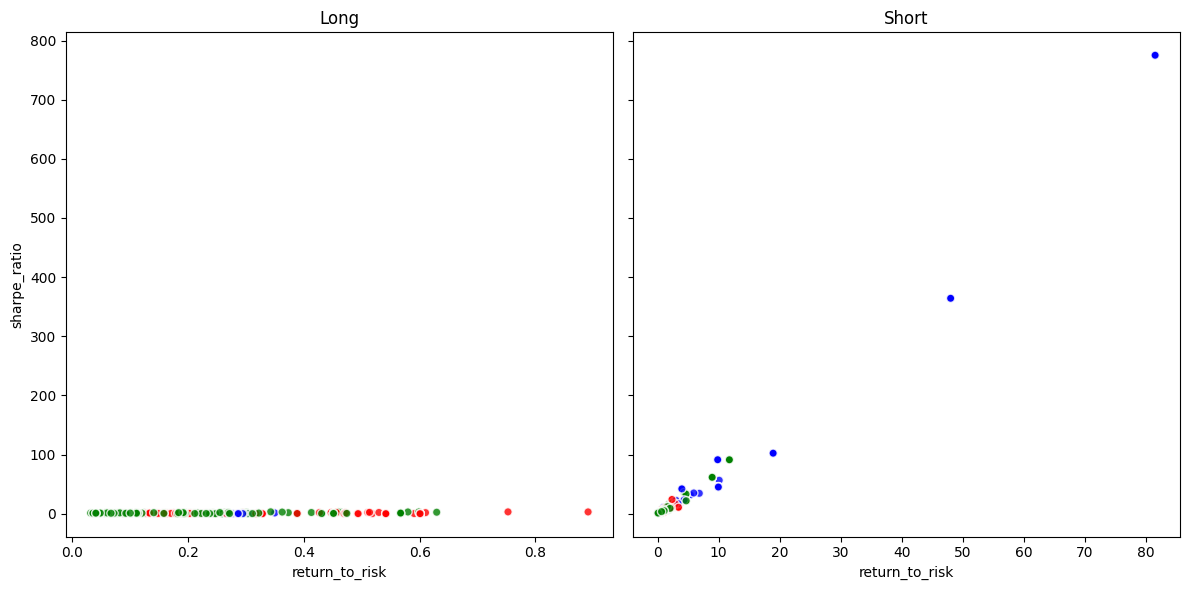

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Long", "Short"]

# Iterate over directions and corresponding axes
for i, position_type in enumerate(["long", "short"]):
    d_analysis = a[a["position_type"] == position_type]
    axes[i].scatter(
        d_analysis["portfolio_std"],
        d_analysis["pnl"],
        c=d_analysis["color"],
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("return_to_risk")
    axes[i].set_ylabel("sharpe_ratio" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [32]:
pm = top["portfolio"]
filtered_simulation = simulation[(simulation["adjclose"]<=top["max_price"]) & (simulation["adjclose"]>=top["min_price"])]
trades = pm.trades(filtered_simulation.copy())
trades = p.additional_date_columns(trades)
portfolio = pm.portfolio(trades.copy(),benchmark.copy())
portfolio = p.additional_date_columns(portfolio)

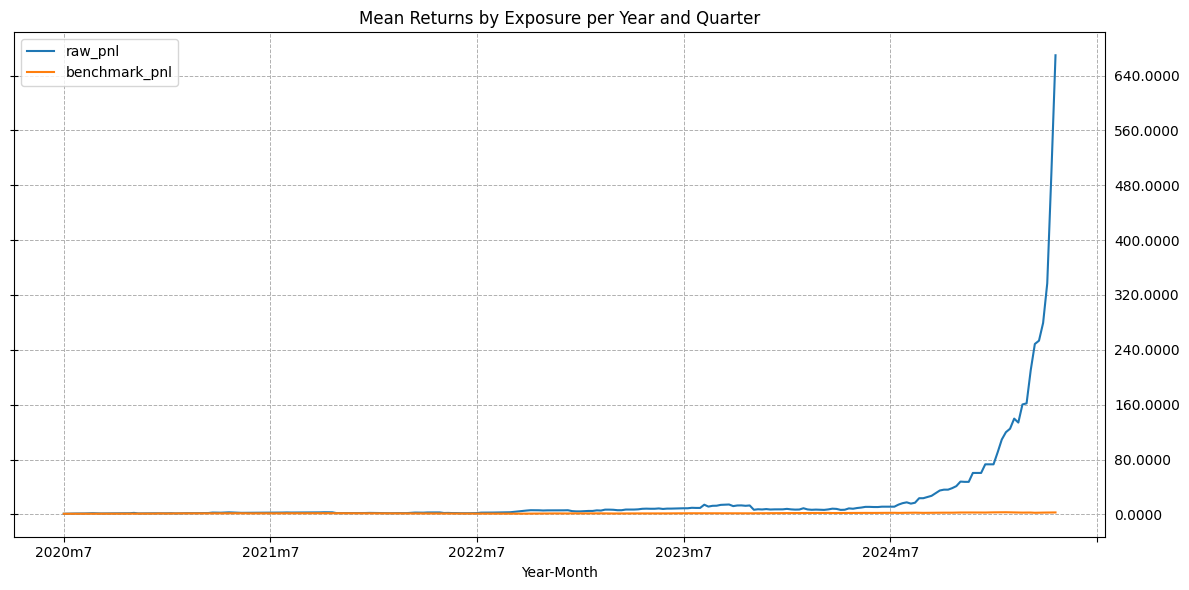

In [33]:
portfolio['Year-Month'] = portfolio["year"].astype(str) + "m" + portfolio["month"].astype(str)
ax = portfolio[["Year-Month","raw_pnl","benchmark_pnl"]].set_index("Year-Month").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [34]:
trades[["group_percentile","return"]].groupby("group_percentile").mean().sort_values("return",ascending=False)

,return
group_percentile,
1,1.033745


In [35]:
len(filtered_simulation["ticker"].unique())

616

In [36]:
trades.sort_values(["date","group_percentile"],ascending=False).dropna().head(40)

,year,week,ticker,date,adjclose,sell_price,standard_dev,atr,risk,group_percentile,rank_percentile,position_type,weight,unweighted_return,stoploss_return,winsorized_return,weighted_return,return,month,quarter
major_key,,,,,,,,,,,,,,,,,,,,
2025_19_1,2025,19,MULN,2025-05-09 00:00:00+00:00,0.3051,0.1993,710.962482,0.620655,434.870612,1,1,-1.0,1,1.346772,1.346772,1.346772,1.346772,1.346772,5,2
2025_18_1,2025,18,MULN,2025-05-02 00:00:00+00:00,0.5900,0.3097,710.970270,1.468570,182.245475,1,1,-1.0,1,1.475085,1.475085,1.385840,1.475085,1.385840,5,2
2025_17_1,2025,17,MULN,2025-04-25 00:00:00+00:00,0.8700,0.6900,711.011789,5.357150,82.968684,1,1,-1.0,1,1.206897,1.206897,1.206897,1.206897,1.206897,4,2
2025_16_1,2025,16,APVO,2025-04-17 00:00:00+00:00,0.9600,0.8619,0.621368,0.440710,0.387589,1,1,-1.0,1,1.102187,1.102187,1.102187,1.102187,1.102187,4,2
2025_15_1,2025,15,APVO,2025-04-10 00:00:00+00:00,1.0000,0.9807,0.622291,0.454200,0.353245,1,1,-1.0,1,1.019300,1.019300,1.019300,1.019300,1.019300,4,2
2025_14_1,2025,14,KNW,2025-04-04 00:00:00+00:00,0.6800,0.5560,0.743200,0.692380,0.476750,1,1,-1.0,1,1.182353,1.182353,1.182353,1.182353,1.182353,4,2
2025_13_1,2025,13,ATCH,2025-03-28 00:00:00+00:00,1.0000,0.7023,1.210770,1.028450,0.505759,1,1,-1.0,1,1.297700,1.297700,1.297700,1.297700,1.297700,3,1
2025_12_1,2025,12,ASBP,2025-03-21 00:00:00+00:00,0.6369,0.6304,3.290910,0.855760,1.220370,1,1,-1.0,1,1.010206,1.010206,1.010206,1.010206,1.010206,3,1
2025_11_1,2025,11,ASBP,2025-03-14 00:00:00+00:00,0.7721,0.6200,4.966952,1.285125,0.966105,1,1,-1.0,1,1.196995,1.196995,1.196995,1.196995,1.196995,3,1


In [37]:
portfolio.sort_values("date",ascending=False).tail(20)

,index,year,week,date,weighted_return,return,pnl,raw_pnl,benchmark,benchmark_pnl,month,quarter,Year-Month
19,19,2020,48,2020-11-27 00:00:00+00:00,1.057256,1.057256,1.587751,1.587751,107.44,1.246259,11,4,2020m11
18,18,2020,47,2020-11-20 00:00:00+00:00,0.664643,0.664643,1.501765,1.501765,101.54,1.177822,11,4,2020m11
17,17,2020,46,2020-11-13 00:00:00+00:00,1.273407,1.273407,2.259506,2.259506,101.11,1.172834,11,4,2020m11
16,16,2020,45,2020-11-06 00:00:00+00:00,1.000000,1.000000,1.774379,1.774379,91.25,1.058462,11,4,2020m11
15,15,2020,44,2020-10-30 00:00:00+00:00,1.038053,1.038053,1.774379,1.774379,86.89,1.007888,10,4,2020m10
14,14,2020,43,2020-10-23 00:00:00+00:00,1.033803,1.033803,1.709334,1.709334,92.01,1.067278,10,4,2020m10
13,13,2020,42,2020-10-16 00:00:00+00:00,1.120238,1.120238,1.653443,1.653443,89.97,1.043614,10,4,2020m10
12,12,2020,41,2020-10-05 00:00:00+00:00,1.000000,1.000000,1.475974,1.475974,87.78,1.018211,10,4,2020m10
11,11,2020,40,2020-09-28 00:00:00+00:00,1.000000,1.000000,1.475974,1.475974,84.46,0.979701,9,3,2020m9
10,10,2020,39,2020-09-25 00:00:00+00:00,1.016601,1.016601,1.475974,1.475974,82.10,0.952326,9,3,2020m9
